In [1]:
import os
os.chdir("../")

# PII Detection: Data Preparation

In [2]:
import pandas as pd

from src.data import rebuild_text, split_rows

Additional Datasets

1. [Nicholas](https://www.kaggle.com/datasets/nbroad/pii-dd-mistral-generated)
2. [Pj Mathematician](https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data/discussion/470921)
3. [Moth](https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data/discussion/469493)
4. [Valentin](https://www.kaggle.com/datasets/valentinwerner/pii-label-specific-data)
5. [Mpware](https://www.kaggle.com/datasets/mpware/pii-mixtral8x7b-generated-essays)
6. [No Fit Just Luck](kaggle.com/datasets/tonyarobertson/mixtral-original-prompt)
7. [Dileep](https://www.kaggle.com/datasets/dileepjayamal/pii-detect-gpt3-5-synthetic-data-8k)

The version of PJM and Moth's dataset that was cleaned by Valentin is used here.

In [3]:
comp_df = pd.read_json("Dataset/competition/train.json")
nbroad_df = pd.read_json("Dataset/nbroad/mixtral-8x7b-v1.json")
pjm_df = pd.read_json("Dataset/pjm_moth/pii_dataset_fixed.json")
nfjl_df = pd.read_json("Dataset/no_fit_just_luck/Fake_data_1850_218.json")
mpware_df = pd.read_json("Dataset/mpware/mpware_mixtral8x7b_v1.1-no-i-username.json")

dileep_df = pd.read_json("Dataset/dileep/PII_Detect_GPT3.5_Generated_data_v1.json")
dileep_df["full_text"] = dileep_df.apply(lambda row: rebuild_text(row["tokens"], row["trailing_whitespace"]), axis=1)
dileep_df["document"] = list(range(dileep_df.shape[0]))

valentin_df = pd.read_json("Dataset/valentin/all_labels.json")
valentin_df["full_text"] = valentin_df.apply(lambda row: rebuild_text(row["tokens"], row["trailing_whitespace"]), axis=1)
valentin_df["document"] = list(range(valentin_df.shape[0]))

moth_df = pd.read_json("Dataset/pjm_moth/moredata_dataset_fixed.json")

newton_df = pd.concat([
    pd.read_json("Dataset/newton/pii_dataset_Gemini_NEWTON_BABA.json"),
    pd.read_json("Dataset/newton/pii_dataset_gemma.json"),
])
newton_df.document = list(range(newton_df.shape[0]))
newton_df.set_index("document", inplace=True)

### Highlevel data overview

In [4]:
print("Competition training data shape:", comp_df.shape)
print("Moth data shape:", moth_df.shape)
print("Nicholas data shape:", nbroad_df.shape)
print("PJ Mathematician data shape:", pjm_df.shape)
print("Valentin's data shape:", valentin_df.shape)
print("MPWare's data shape:", mpware_df.shape)
print("Dileep's data shape:", dileep_df.shape)
print("No Fit Just Luck's data shape:", nfjl_df.shape)
print("Newton's data shape:", newton_df.shape)

Competition training data shape: (6807, 5)
Moth data shape: (2000, 5)
Nicholas data shape: (2355, 5)
PJ Mathematician data shape: (4434, 5)
Valentin's data shape: (4367, 5)
MPWare's data shape: (2692, 5)
Dileep's data shape: (8281, 5)
No Fit Just Luck's data shape: (1850, 5)
Newton's data shape: (5169, 4)


### Token distribution

https://www.kaggle.com/code/ishfar/pii-data-preparation-cv-stride-viz-and-w-b/edit

In [5]:
from sklearn.preprocessing import MultiLabelBinarizer
from itertools import chain

In [6]:
def encode_labels(df):
    df["unique_labels"] = df["labels"].apply(
        lambda x: list(set([l.split("-")[1] for l in x if l != "O"]))
    )

    # add 1-hot encoding
    mlb = MultiLabelBinarizer()
    one_hot_encoded = mlb.fit_transform(df["unique_labels"])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)
    df = pd.concat([df, one_hot_df], axis=1)

    # add 'OTHER' column
    df["NO_PII"] = df["unique_labels"].apply(lambda x: 1 if len(x) == 0 else 0)

    return df, list(mlb.classes_) + ["NO_PII"]


comp_df, label_classes = encode_labels(comp_df)
moth_df, label_classes = encode_labels(moth_df)
pjm_df, label_classes = encode_labels(pjm_df)
nbroad_df, label_classes = encode_labels(nbroad_df)
valentin_df, label_classes = encode_labels(valentin_df)
nfjl_df, label_classes = encode_labels(nfjl_df)
dileep_df, label_classes = encode_labels(dileep_df)
newton_df, label_classes = encode_labels(newton_df)
mpware_df, label_classes = encode_labels(mpware_df)

In [7]:
for df in [comp_df, moth_df, pjm_df, nbroad_df, valentin_df, nfjl_df, dileep_df, newton_df, mpware_df]:
    all_labels = sorted(list(set(chain(*[x for x in df.labels.values]))))
    print(all_labels)

['B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-ID_NUM', 'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'I-URL_PERSONAL', 'O']
['B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-ID_NUM', 'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'O']
['B-EMAIL', 'B-NAME_STUDENT', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'O']
['B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-ID_NUM', 'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'O']
['B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'O']
['B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-ID_NUM', 'I

In [8]:
newton_df = newton_df[~newton_df.labels.apply(lambda x: any(y in ["I-EMAIL", "I-USERNAME"] for y in x))]
newton_df.shape

(4726, 13)

### CV Split

In [9]:
# Shuffle the dataframe
comp_df = comp_df.sample(frac=1, random_state=42)

# Create a 'valid' column and set it to False
comp_df['valid'] = False

# Define the validation numbers
val_nums = {
    'EMAIL': 12,
    'ID_NUM': 12,
    'NAME_STUDENT': 100,
    'PHONE_NUM': 4,
    'STREET_ADDRESS': 2,
    'URL_PERSONAL': 20,
    'USERNAME': 5,
    'NO_PII': 1000, 
}

# For each class in val_nums, randomly select the specified number of examples and set 'valid' to True
for label, num in val_nums.items():
    valid_indices = comp_df[comp_df[label] == 1].sample(n=num, random_state=42).index
    comp_df.loc[valid_indices, 'valid'] = True


# Let's double check the classes per split:
for col in label_classes:
    print(f'VALID {col}: {comp_df[comp_df.valid == True][col].sum()}')
    print(f'TRAIN {col}: {comp_df[comp_df.valid == False][col].sum()}')

VALID EMAIL: 13
TRAIN EMAIL: 11
VALID ID_NUM: 13
TRAIN ID_NUM: 20
VALID NAME_STUDENT: 124
TRAIN NAME_STUDENT: 767
VALID PHONE_NUM: 4
TRAIN PHONE_NUM: 0
VALID STREET_ADDRESS: 2
TRAIN STREET_ADDRESS: 0
VALID URL_PERSONAL: 26
TRAIN URL_PERSONAL: 46
VALID USERNAME: 5
TRAIN USERNAME: 0
VALID NO_PII: 1000
TRAIN NO_PII: 4862


### Extending Training Data

In [10]:
pjm_df["valid"] = False
nbroad_df["valid"] = False
moth_df["valid"] = False
valentin_df["valid"] = False
nfjl_df["valid"] = False
mpware_df["valid"] = False
dileep_df["valid"] = False
newton_df["valid"] = False

In [11]:
comp_df["source"] = "Competition"
pjm_df["source"] = "PJ-Mathematician"
nbroad_df["source"] = "Nicholas"
moth_df["source"] = "Moth"
valentin_df["source"] = "Valentin"
nfjl_df["source"] = "No-fit-just-luck"
mpware_df["source"] = "MPWare"
dileep_df["source"] = "Dileep"
newton_df["source"] = "Newton"

In [12]:
df = pd.concat([comp_df, nbroad_df, moth_df, nfjl_df, mpware_df, pjm_df, dileep_df, valentin_df, newton_df])
df = df.sample(frac=1, random_state=42)
df.shape

(37512, 16)

In [13]:
df[df.valid == True].shape, df[df.valid==False].shape

((1146, 16), (36366, 16))

In [14]:
df.head(3)

,document,full_text,tokens,trailing_whitespace,labels,unique_labels,EMAIL,ID_NUM,NAME_STUDENT,PHONE_NUM,STREET_ADDRESS,URL_PERSONAL,USERNAME,NO_PII,valid,source
400,NaN,"In today's digital age, our personal informati...","[In, today, 's, digital, age, ,, our, personal...","[True, False, True, True, False, True, True, T...","[O, O, O, O, O, B-PHONE_NUM, O, O, O, O, O, O,...",[PHONE_NUM],0,0.0,0,1,0,0,0,0,False,Newton
4346,fab1df9d-2df9-4ed2-b6ea-f6ecc365aa73,"As a salesperson named Joel Rousseau, I strive...","[As, a, salesperson, named, Joel, Rousseau, ,,...","[True, True, True, True, True, False, True, Tr...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O...","[STREET_ADDRESS, NAME_STUDENT, EMAIL]",1,NaN,1,0,1,0,0,0,False,PJ-Mathematician
1195,42534cc4-e5cd-4b4a-b7d2-f11caf1d6228,"My name is Ming Neumann, and I've been a mecha...","[My, name, is, Ming, Neumann, ,, and, I, 've, ...","[True, True, True, True, False, True, True, Fa...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O...","[PHONE_NUM, STREET_ADDRESS, NAME_STUDENT, EMAIL]",1,NaN,1,1,1,0,0,0,False,PJ-Mathematician


<Axes: >

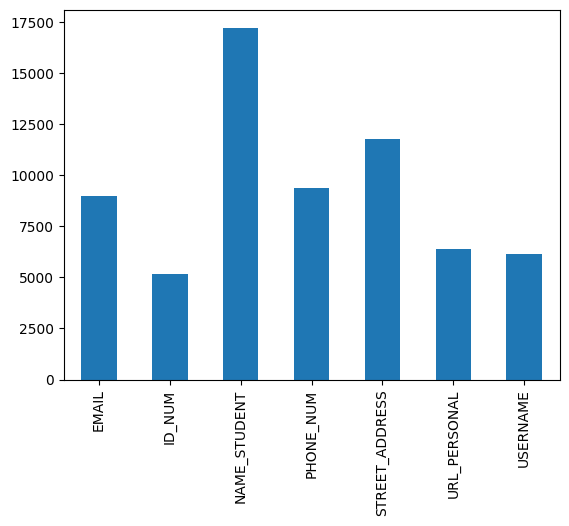

In [15]:
df[df.valid == False].loc[:, "EMAIL":"USERNAME"].sum().plot.bar()

<Axes: >

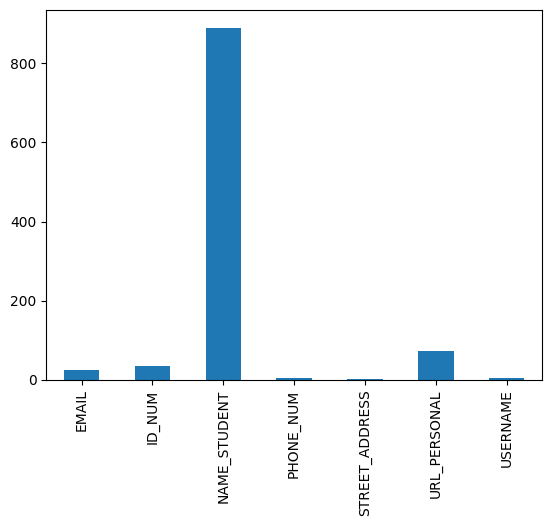

In [16]:
df[df.source == "Competition"].loc[:, "EMAIL":"USERNAME"].sum().plot.bar()

Setting `document` column to be the index number

In [17]:
df["document"] = df.index.astype(int)

In [18]:
df.head(3)

,document,full_text,tokens,trailing_whitespace,labels,unique_labels,EMAIL,ID_NUM,NAME_STUDENT,PHONE_NUM,STREET_ADDRESS,URL_PERSONAL,USERNAME,NO_PII,valid,source
400,400,"In today's digital age, our personal informati...","[In, today, 's, digital, age, ,, our, personal...","[True, False, True, True, False, True, True, T...","[O, O, O, O, O, B-PHONE_NUM, O, O, O, O, O, O,...",[PHONE_NUM],0,0.0,0,1,0,0,0,0,False,Newton
4346,4346,"As a salesperson named Joel Rousseau, I strive...","[As, a, salesperson, named, Joel, Rousseau, ,,...","[True, True, True, True, True, False, True, Tr...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O...","[STREET_ADDRESS, NAME_STUDENT, EMAIL]",1,NaN,1,0,1,0,0,0,False,PJ-Mathematician
1195,1195,"My name is Ming Neumann, and I've been a mecha...","[My, name, is, Ming, Neumann, ,, and, I, 've, ...","[True, True, True, True, False, True, True, Fa...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O...","[PHONE_NUM, STREET_ADDRESS, NAME_STUDENT, EMAIL]",1,NaN,1,1,1,0,0,0,False,PJ-Mathematician


### Truncation with Stride

[Reason](https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data/discussion/473011)

In [19]:
def add_token_indices(doc_tokens):
    token_indices = list(range(len(doc_tokens)))
    return token_indices

df['token_indices'] = df['tokens'].apply(add_token_indices)

In [20]:
max_length = 512
doc_stride = 192
stride_df = split_rows(df, max_length, doc_stride)
stride_df, label_classes = encode_labels(stride_df)

print("Length of original data:", len(df))
print("Length of strided data:", len(stride_df))

Length of original data: 37512
Length of strided data: 70065


Save as CSV

In [21]:
df.to_csv("Dataset/cv_data.csv", index=False)
stride_df.to_csv("Dataset/cv_strided_data.csv", index=False)

### Weights and Biases

In [22]:
import wandb

wandb.login(key="0bf204609ea345c7c595565d736a9d62ca69f838")
wandb.init(project='Kaggle-PII', job_type='preprocessing')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shakleenishfar. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ishfar/.netrc


In [23]:
df.to_parquet('raw_data.parquet', index=False)
stride_df.to_parquet('stride_data.parquet', index=False)

raw_data = wandb.Artifact(name="raw_data", type="dataset")
raw_data.add_file('raw_data.parquet')
wandb.log_artifact(raw_data)

processed_data = wandb.Artifact(name="processed_data", type="dataset")
processed_data.add_file('stride_data.parquet')
wandb.log_artifact(processed_data)

<Artifact processed_data>

In [24]:
import spacy
from spacy.tokens import Span
from spacy import displacy

nlp = spacy.blank("en")

options = {
    "colors": {
        "B-NAME_STUDENT": "aqua",
        "I-NAME_STUDENT": "skyblue",
        "B-EMAIL": "limegreen",
        "I-EMAIL": "lime",
        "B-USERNAME": "hotpink",
        "I-USERNAME": "lightpink",
        "B-ID_NUM": "purple",
        "I-ID_NUM": "rebeccapurple",
        "B-PHONE_NUM": "red",
        "I-PHONE_NUM": "salmon",
        "B-URL_PERSONAL": "silver",
        "I-URL_PERSONAL": "lightgray",
        "B-STREET_ADDRESS": "brown",
        "I-STREET_ADDRESS": "chocolate",
    }
}

def visualize(row):
    doc = nlp(row.full_text)
    doc.ents = [
        Span(doc, idx, idx + 1, label=label)
        for idx, label in enumerate(row.labels)
        if label != "O"
    ]
    html = displacy.render(doc, style="ent", jupyter=False, options=options)
    return html

In [25]:
wandb_htmls = [wandb.Html(visualize(row)) for _, row in df.iterrows()]
df['visualization'] = wandb_htmls
table = wandb.Table(dataframe=df)
wandb.log({'original_dataset': table})

/media/ishfar/New Volume/Studies/Projects/Kaggle/PII_Detection/venv/lib/python3.11/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [26]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
